In [1]:
pip install numpy pandas matplotlib scikit-learn xgboost seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
DATA_PATH = "data/heart_attack_prediction_dataset.csv"
RANDOM_STATE = 42


In [4]:
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nInfo:")
print(df.info())

Shape: (8763, 26)

Columns: ['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Blood Pressure', 'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country', 'Continent', 'Hemisphere', 'Heart Attack Risk']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 

In [5]:
if "target" not in df.columns and "Heart Attack Risk" in df.columns:
    df = df.rename(columns={"Heart Attack Risk": "target"})

df = df.rename(columns={
    "Patient ID": "patient_id",
    "Age": "age",
    "Sex": "sex",
    "Cholesterol": "cholesterol",
    "Blood Pressure": "blood_pressure",
    "Heart Rate": "heart_rate",
    "Diabetes": "diabetes",
    "Family History": "family_history",
    "Smoking": "smoking",
    "Obesity": "obesity",
    "Alcohol Consumption": "alcohol_consumption",
    "Exercise Hours Per Week": "exercise_hours_per_week",
    "Diet": "diet",
    "Previous Heart Problems": "previous_heart_problems",
    "Medication Use": "medication_use",
    "Stress Level": "stress_level",
    "Sedentary Hours Per Day": "sedentary_hours_per_day",
    "Income": "income",
    "BMI": "bmi",
    "Triglycerides": "triglycerides",
    "Physical Activity Days Per Week": "physical_activity_days_per_week",
    "Sleep Hours Per Day": "sleep_hours_per_day",
    "Country": "country",
    "Continent": "continent",
    "Hemisphere": "hemisphere",
}, errors="ignore")

# Parse blood pressure into numeric columns and drop raw column
if "blood_pressure" in df.columns:
    bp_parts = df["blood_pressure"].astype(str).str.split("/", n=1, expand=True)
    df["systolic_bp"] = pd.to_numeric(bp_parts[0], errors="coerce")
    df["diastolic_bp"] = pd.to_numeric(bp_parts[1], errors="coerce")
    df = df.drop(columns=["blood_pressure"])

# Drop id (high-cardinality identifier)
df = df.drop(columns=["patient_id"], errors="ignore")

# Categorical Encoding
# Sex: Male/Female -> 0/1
if "sex" in df.columns and df["sex"].dtype == "object":
    le = LabelEncoder()
    df["sex"] = le.fit_transform(df["sex"].astype(str))

/var/folders/9g/t9llppjn3_gd69qmw3dftqw40000gn/T/ipykernel_914/2206196621.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=df, palette='pastel')


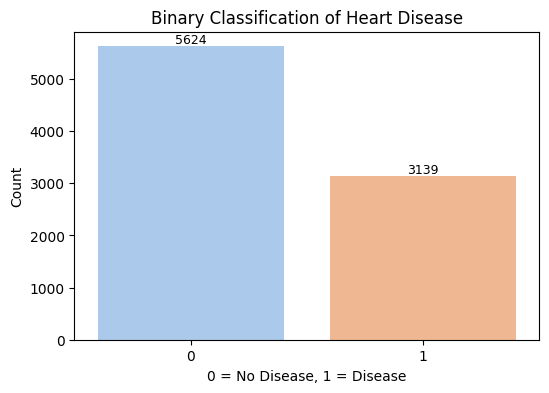

Target Class Counts:
 target
0    5624
1    3139
Name: count, dtype: int64

Target Class Percentages:
 target
0    64.178934
1    35.821066
Name: proportion, dtype: float64


In [6]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='target', data=df, palette='pastel')

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9)

plt.title('Binary Classification of Heart Disease')
plt.xlabel('0 = No Disease, 1 = Disease')
plt.ylabel('Count')
plt.show()

# Print counts separately
print("Target Class Counts:\n", df['target'].value_counts())
print("\nTarget Class Percentages:\n", df['target'].value_counts(normalize=True) * 100)

In [7]:
feature_cols = [c for c in df.columns if c != "target"]
numeric_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in feature_cols if c not in numeric_cols]

print("\nNumeric columns:", numeric_cols)
print("\nCategorical columns:", cat_cols)


Numeric columns: ['age', 'sex', 'cholesterol', 'heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'previous_heart_problems', 'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', 'physical_activity_days_per_week', 'sleep_hours_per_day', 'systolic_bp', 'diastolic_bp']

Categorical columns: ['diet', 'country', 'continent', 'hemisphere']


In [8]:
df[numeric_cols].describe()

,age,sex,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,...,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,systolic_bp,diastolic_bp
count,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,...,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000
mean,53.707977,0.697364,259.877211,75.021682,0.652288,0.492982,0.896839,0.501426,0.598083,10.014284,...,0.498345,5.469702,5.993690,158263.181901,28.891446,417.677051,3.489672,7.023508,135.075659,85.156111
std,21.249509,0.459425,80.863276,20.550948,0.476271,0.499979,0.304186,0.500026,0.490313,5.783745,...,0.500026,2.859622,3.466359,80575.190806,6.319181,223.748137,2.282687,1.988473,26.349976,14.676565
min,18.000000,0.000000,120.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002442,...,0.000000,1.000000,0.001263,20062.000000,18.002337,30.000000,0.000000,4.000000,90.000000,60.000000
25%,35.000000,0.000000,192.000000,57.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.981579,...,0.000000,3.000000,2.998794,88310.000000,23.422985,225.500000,2.000000,5.000000,112.000000,72.000000
50%,54.000000,1.000000,259.000000,75.000000,1.000000,0.000000,1.000000,1.000000,1.000000,10.069559,...,0.000000,5.000000,5.933622,157866.000000,28.768999,417.000000,3.000000,7.000000,135.000000,85.000000
75%,72.000000,1.000000,330.000000,93.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.050018,...,1.000000,8.000000,9.019124,227749.000000,34.324594,612.000000,5.000000,9.000000,158.000000,98.000000
max,90.000000,1.000000,400.000000,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.998709,...,1.000000,10.000000,11.999313,299954.000000,39.997211,800.000000,7.000000,10.000000,180.000000,110.000000


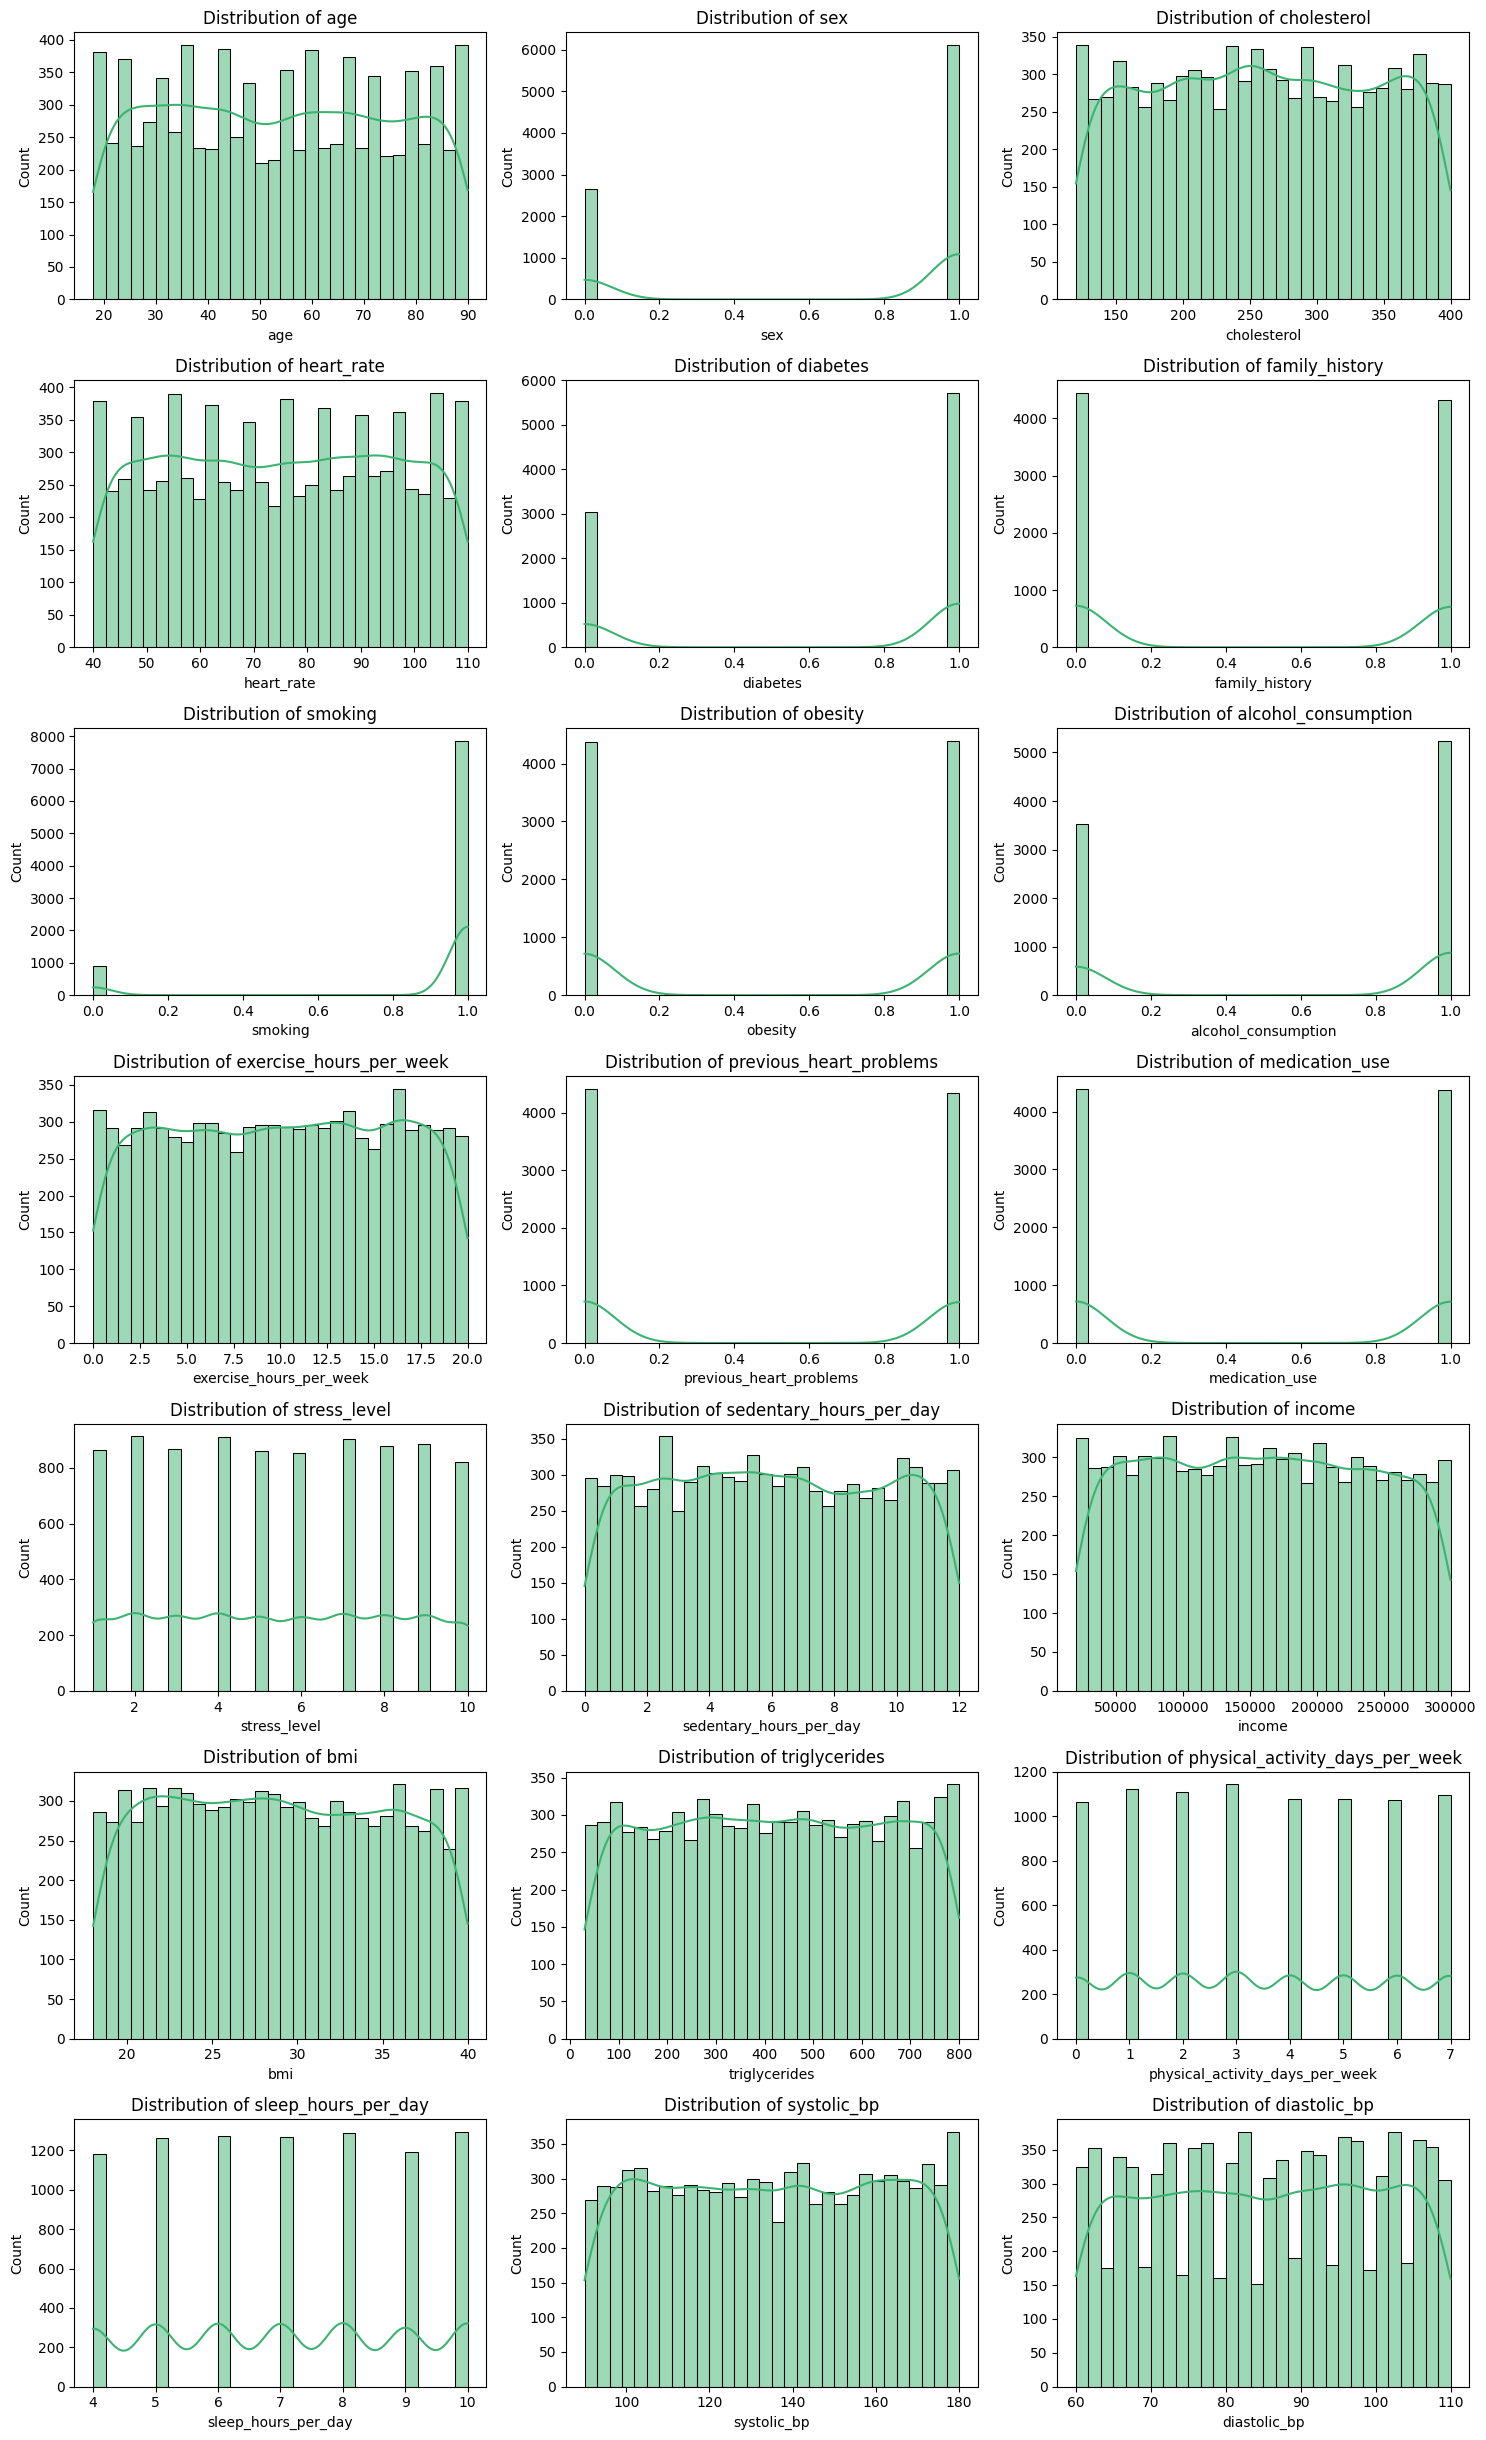

In [9]:
# Histograms for numeric features
if len(numeric_cols) == 0:
    print('No numerical columns to plot.')
else:
    ncols = 3
    nrows = math.ceil(len(numeric_cols) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3.5 * nrows))

    axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]

    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        sns.histplot(df[col], kde=True, bins=30, color='mediumseagreen', ax=ax)
        ax.set_title(f'Distribution of {col}')

    for ax in axes[len(numeric_cols):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

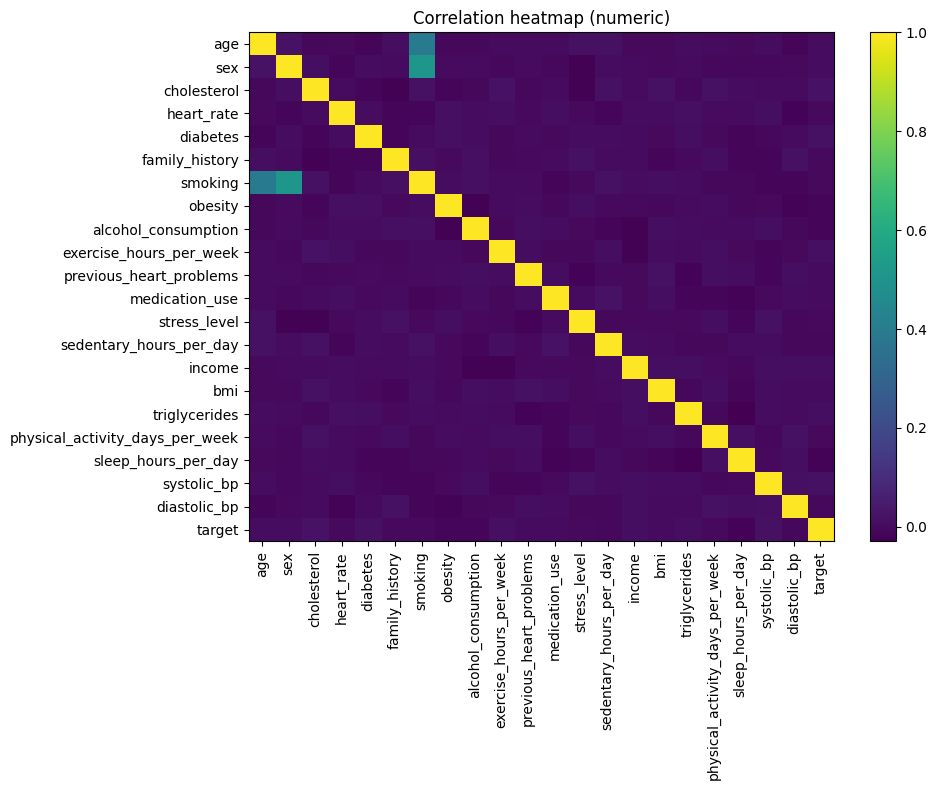

In [10]:
if len(numeric_cols) >= 2:
    corr = df[numeric_cols + ["target"]].corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    plt.imshow(corr, aspect="auto")
    plt.title("Correlation heatmap (numeric)")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

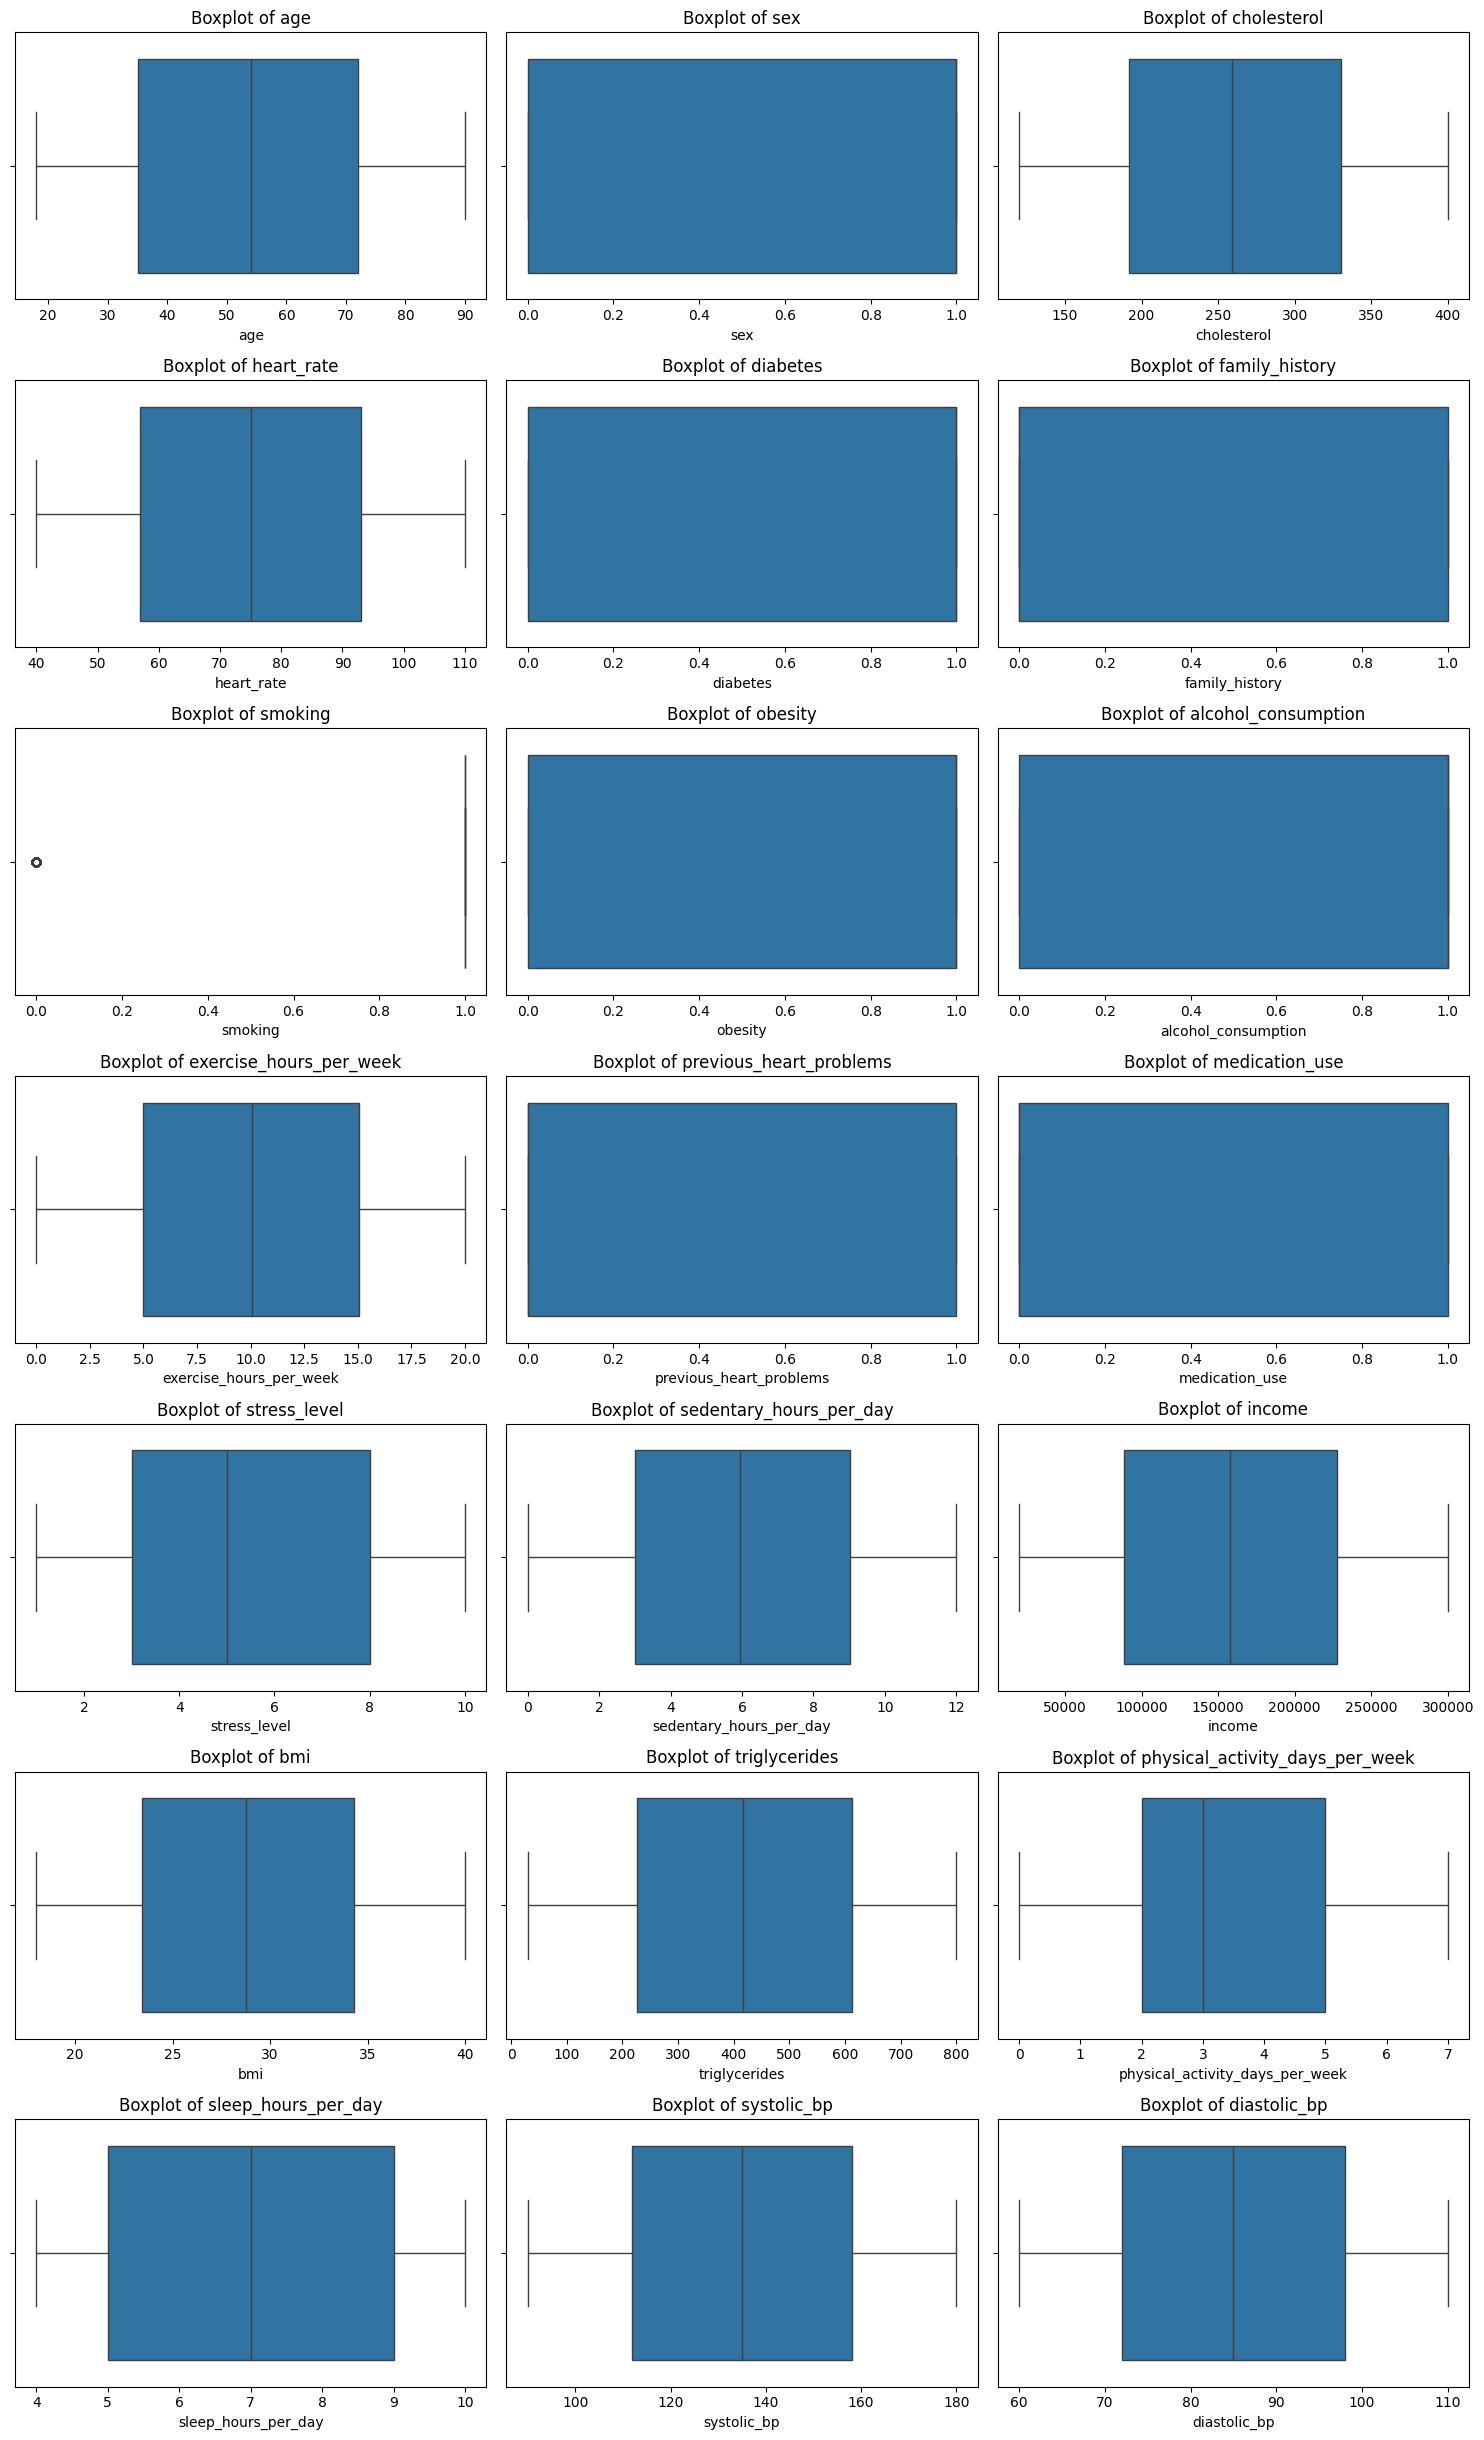

In [11]:
if len(numeric_cols) == 0:
    print('No numerical columns to plot.')
else:
    ncols = 3
    nrows = math.ceil(len(numeric_cols) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3.5 * nrows))

    axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]

    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        sns.boxplot(x=df[col], ax=ax)
        ax.set_title(f'Boxplot of {col}')

    for ax in axes[len(numeric_cols):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

In [12]:
# Compute skewness of numerical features to assess distribution asymmetry
# (positive = right skew, negative = left skew, near 0 = roughly symmetric)
df[numeric_cols].skew()

age                                0.028498
sex                               -0.859374
cholesterol                       -0.000955
heart_rate                        -0.003227
diabetes                          -0.639647
family_history                     0.028080
smoking                           -2.609778
obesity                           -0.005707
alcohol_consumption               -0.400174
exercise_hours_per_week           -0.016387
previous_heart_problems            0.016664
medication_use                     0.006620
stress_level                       0.008389
sedentary_hours_per_day            0.017974
income                             0.021792
bmi                                0.035996
triglycerides                     -0.001915
physical_activity_days_per_week    0.017822
sleep_hours_per_day                0.000357
systolic_bp                       -0.002661
diastolic_bp                      -0.023375
dtype: float64

In [13]:
for col in cat_cols:
    print(df[col].value_counts())
    print("\n\n")

diet
Healthy      2960
Average      2912
Unhealthy    2891
Name: count, dtype: int64



country
Germany           477
Argentina         471
Brazil            462
United Kingdom    457
Australia         449
Nigeria           448
France            446
Canada            440
China             436
New Zealand       435
Japan             433
Italy             431
Spain             430
Colombia          429
Thailand          428
South Africa      425
Vietnam           425
United States     420
India             412
South Korea       409
Name: count, dtype: int64



continent
Asia             2543
Europe           2241
South America    1362
Australia         884
Africa            873
North America     860
Name: count, dtype: int64



hemisphere
Northern Hemisphere    5660
Southern Hemisphere    3103
Name: count, dtype: int64





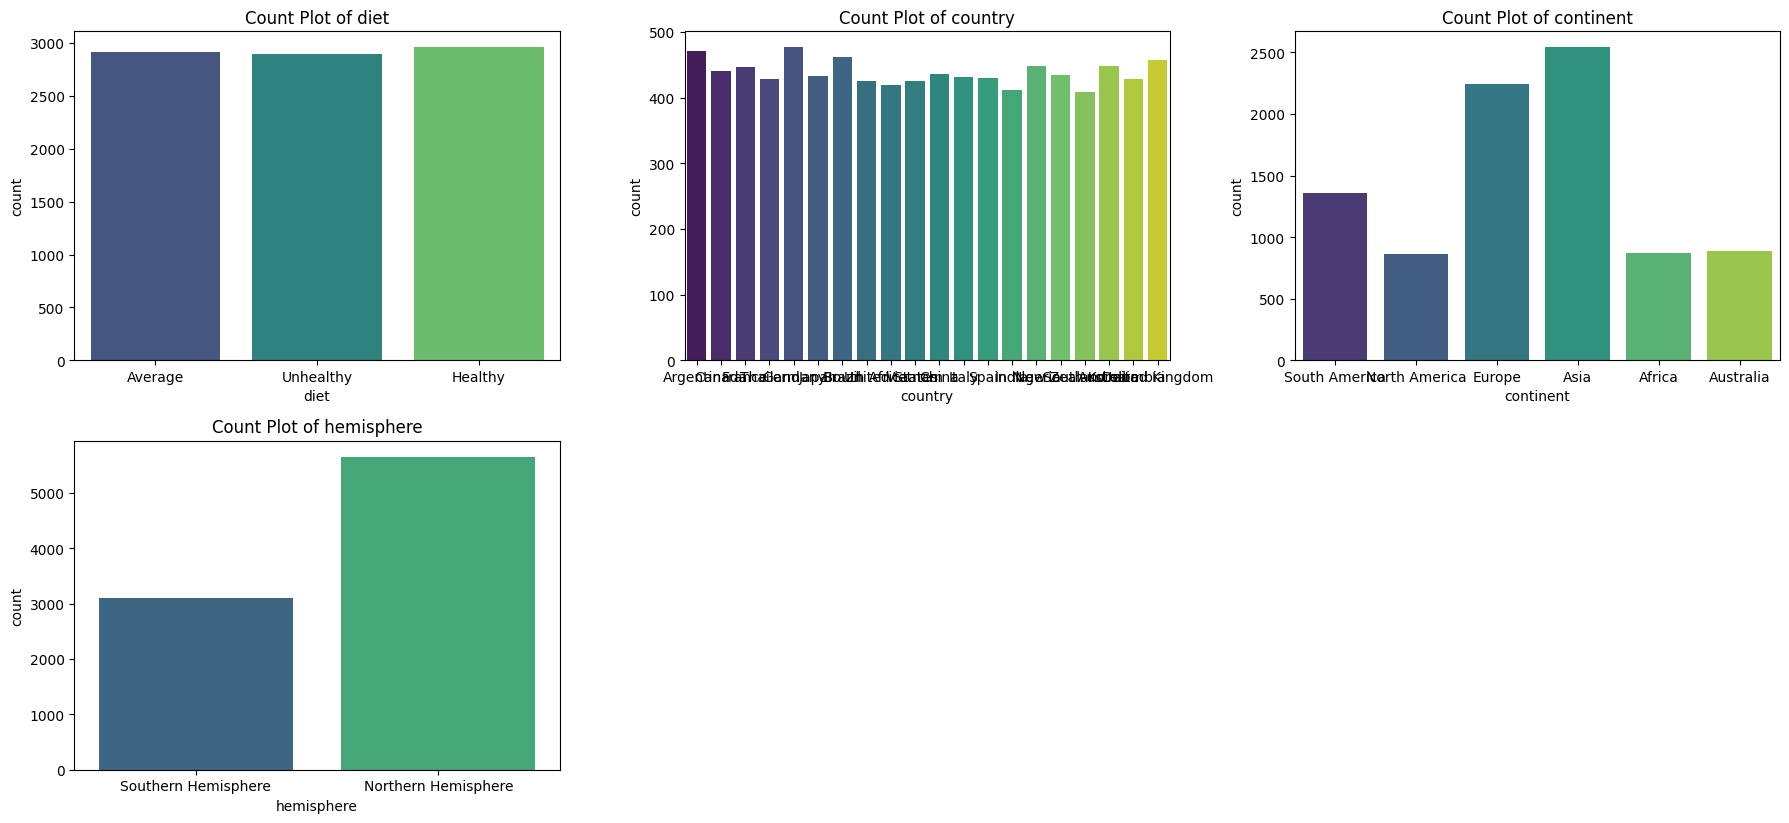

In [14]:
plt.figure(figsize=(18, 12))
for i, col in enumerate(cat_cols):
    plt.subplot(3, 3, i + 1)
    sns.countplot(
    x=col,
    data=df,
    hue=col,
    palette="viridis",
    legend=False
)
    plt.title(f'Count Plot of {col}')
plt.tight_layout()
plt.show()

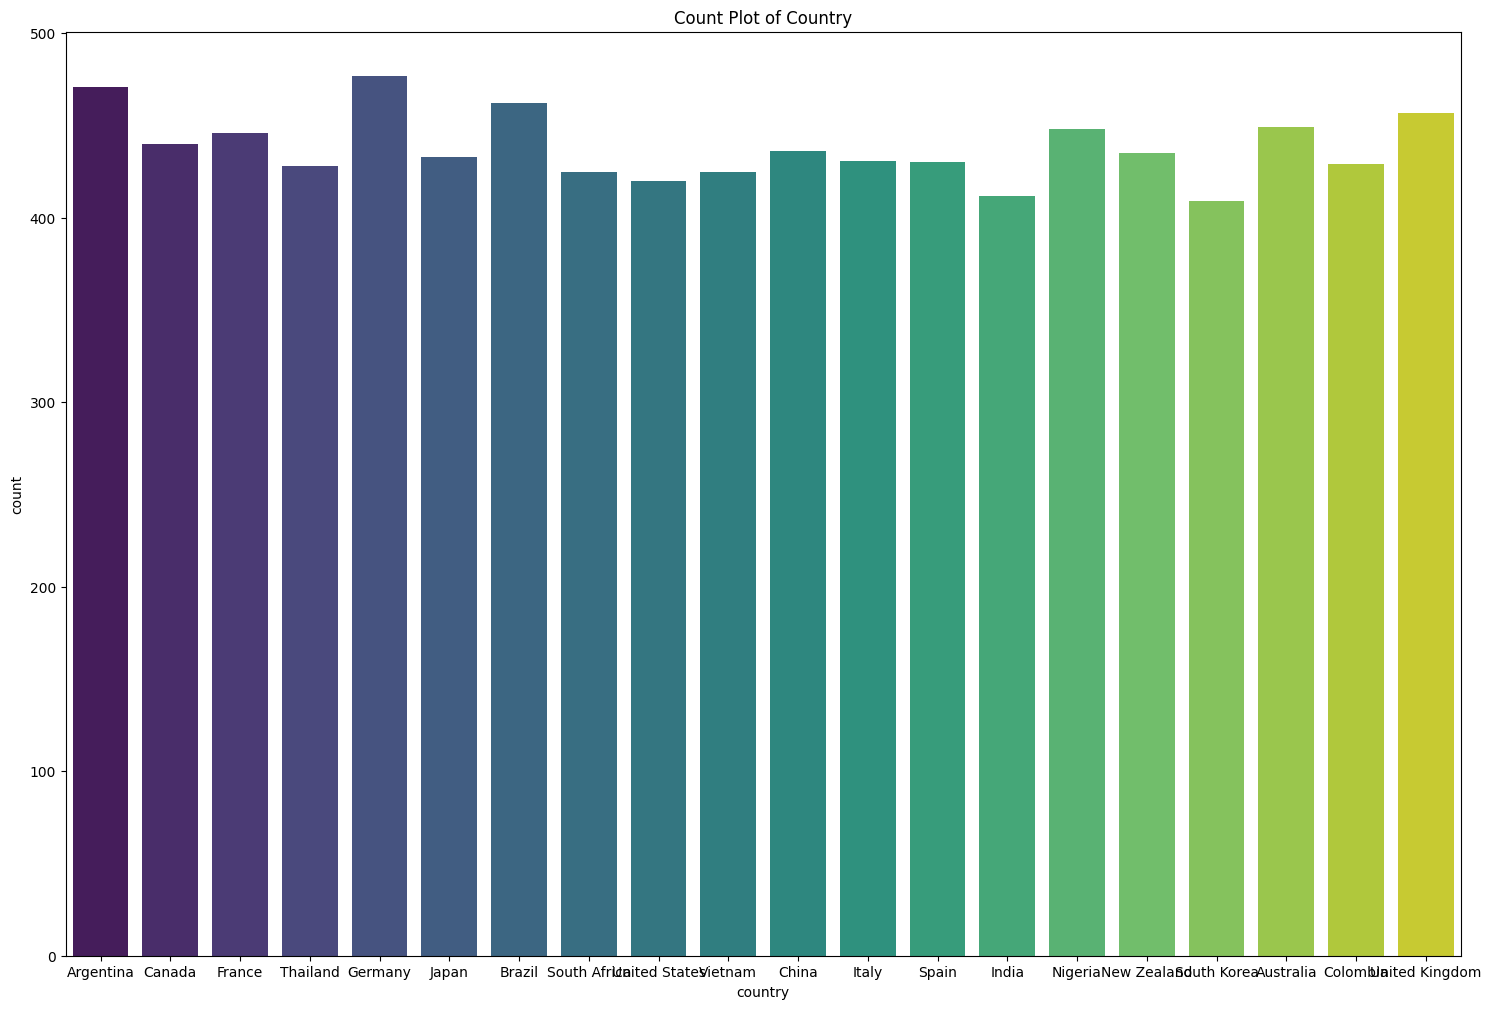

In [15]:
plt.figure(figsize=(18, 12))
sns.countplot(
    x="country",
    data=df,
    hue="country",
    palette="viridis",
    legend=False
)
plt.title('Count Plot of Country')
plt.show()

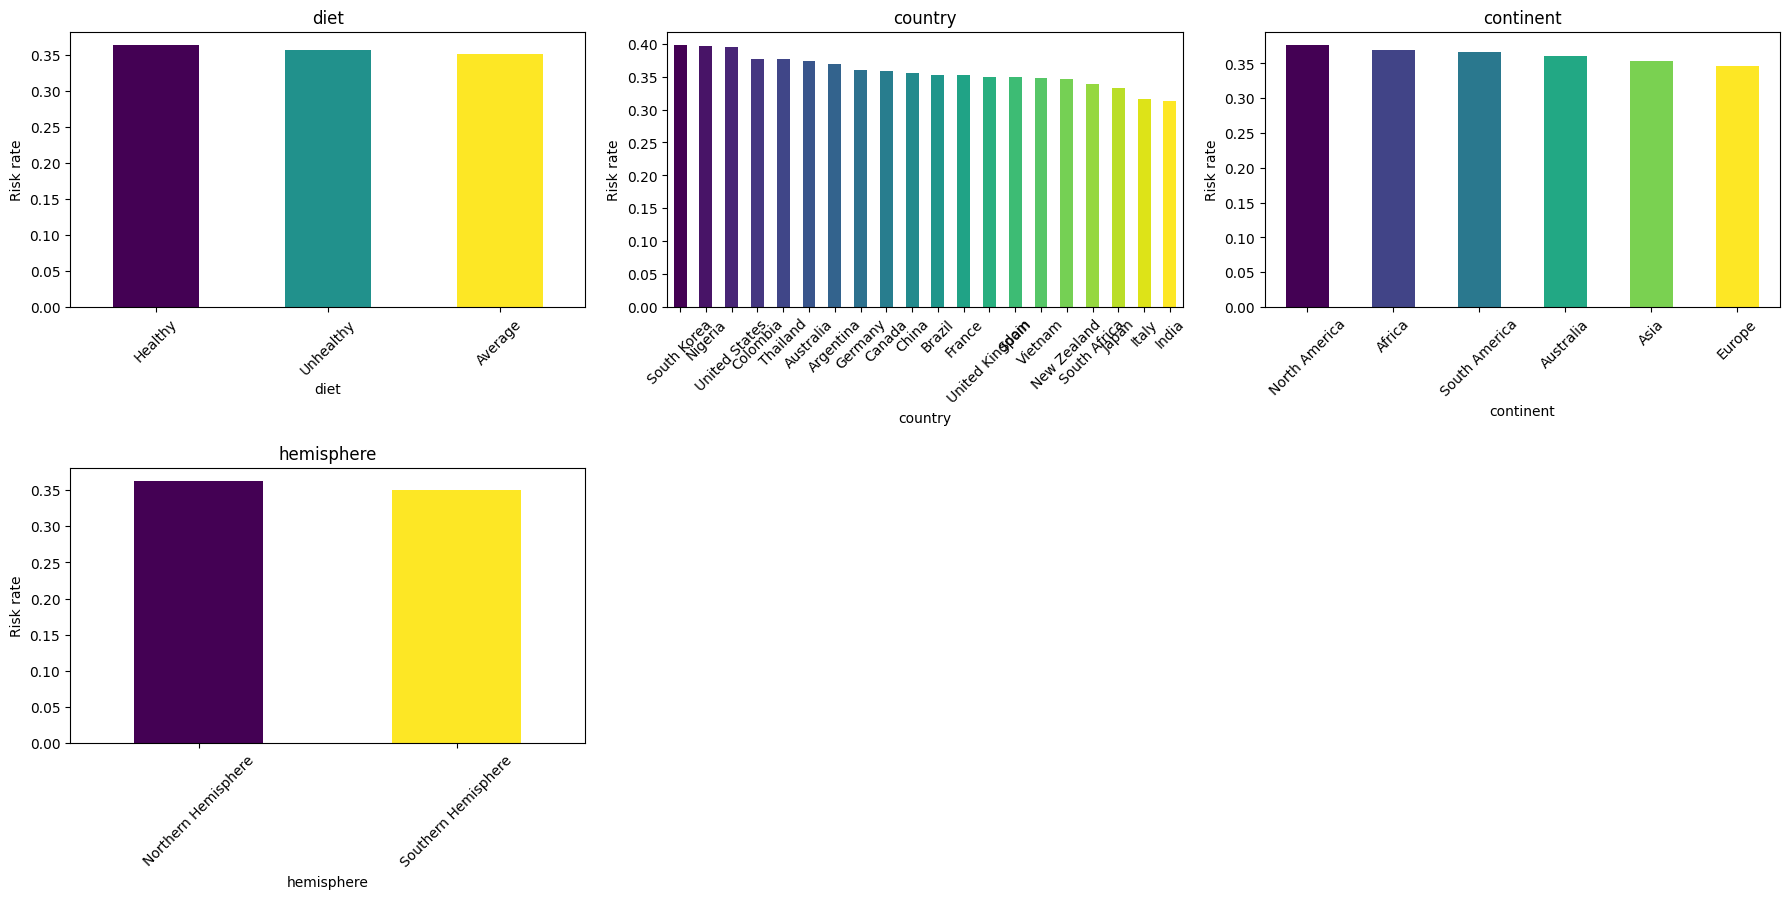

In [16]:
'''Although `target` is binary (0 = no risk, 1 = risk), taking the mean after grouping
is valid and intentional. The mean of a binary variable represents the proportion
of positive cases (risk = 1) within each category. In other words, each bar shows
the observed heart attack risk rate for that category, not a prediction.'''

plt.figure(figsize=(18, 12))

for i, col in enumerate(cat_cols):
    plt.subplot(3, 3, i + 1)

    values = df.groupby(col)["target"].mean().sort_values(ascending=False)
    colors = plt.cm.viridis(np.linspace(0, 1, len(values)))

    values.plot(kind="bar", color=colors)

    plt.title(col)
    plt.ylabel("Risk rate")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [17]:
## Train-test Splitting

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

In [18]:
'''Define preprocessing pipelines for numerical and categorical features.
Although the dataset does not contain missing values, imputers are included
as a safety measure to ensure robustness after feature engineering and for
potential future data. Numerical features are imputed using the median and
scaled, while categorical features are imputed using the most frequent value
and one hot encoded. `remainder="drop"` ensures that only explicitly defined
features are kept and any unused columns are excluded from the model input.'''

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)


In [19]:
'''
Define the five chosen machine learning models.
1. Logistic Regression
2. Support Vector Machine
3. Random Forest
4. XGBoost
5. Neural Network (MLP)
All models are later wrapped in pipelines with preprocessing.
'''

# Logistic Regression
logreg = LogisticRegression(max_iter=4000, random_state=RANDOM_STATE, solver="lbfgs")

# Support Vector Machine
# NOTE: probability=True is required for predict_proba, which is used by evaluate_model,
# soft voting, and stacking with stack_method="predict_proba".
svm = SVC(
    probability=True,
    class_weight="balanced",
    random_state=RANDOM_STATE
 )

# Random Forest
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
 )

# XGBoost model (gradient boosting)
xgb_name = "XGBoost"
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"
 )

# Neural network (MLP)
nn = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    alpha=0.0005,
    learning_rate_init=0.001,
    max_iter=400,
    random_state=RANDOM_STATE
 )


In [20]:
'''Wrap each model with the preprocessing pipeline to ensure
identical feature transformations across all models'''

models = {
    "Logistic Regression": Pipeline([("preprocess", preprocess), ("model", logreg)]),
    "SVM": Pipeline([("preprocess", preprocess), ("model", svm)]),
    "Random Forest": Pipeline([("preprocess", preprocess), ("model", rf)]),
    xgb_name: Pipeline([("preprocess", preprocess), ("model", xgb)]),
    "Neural Network": Pipeline([("preprocess", preprocess), ("model", nn)]),
}


In [21]:
'''
Perform 5-fold stratified cross validation on the training data only.
Although the model has not been explicitly trained yet, `cross_val_score`
automatically fits the entire pipeline from scratch in each fold, trains it
on a subset of the training data, and evaluates it on the remaining fold.
This process provides a robust, leakage-free estimate of model performance
and enables fair comparison between models before final training and testing.
ROC AUC is used as a threshold-independent metric suitable for imbalanced data.

'''

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_rows = []
for name, pipe in models.items():
    scores = cross_val_score(
        pipe, X_train, y_train,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    )
    cv_rows.append((name, scores.mean(), scores.std()))
    print(f"{name:22s} mean={scores.mean():.4f} std={scores.std():.4f}")

cv_df = pd.DataFrame(
    cv_rows,
    columns=["Model", "ROC_AUC_mean", "ROC_AUC_std"]
).sort_values("ROC_AUC_mean", ascending=False)

print(cv_df)


Logistic Regression    mean=0.4990 std=0.0143
SVM                    mean=0.4904 std=0.0114
Random Forest          mean=0.4909 std=0.0167
XGBoost                mean=0.4988 std=0.0116
Neural Network         mean=0.4961 std=0.0192
                 Model  ROC_AUC_mean  ROC_AUC_std
0  Logistic Regression      0.499039     0.014331
3              XGBoost      0.498809     0.011566
4       Neural Network      0.496138     0.019186
2        Random Forest      0.490866     0.016721
1                  SVM      0.490436     0.011421


In [22]:
'''The consistently low ROC AUC values observed across all evaluated models indicate
that the available features provide limited predictive signal for distinguishing
between individuals with and without heart attack risk in this dataset. The fact
that diverse model families (linear, kernel-based, tree-based, boosting, and neural
networks) exhibit similarly low performance suggests that this outcome is driven
by limitations in the dataset or the target definition, rather than deficiencies
in preprocessing, feature engineering, or model selection. ROC AUC was used as the
primary evaluation metric because it measures a model’s ability to rank positive
cases above negative cases across all classification thresholds and is robust to
class imbalance, making it appropriate for binary medical risk prediction tasks.
'''

'The consistently low ROC AUC values observed across all evaluated models indicate\nthat the available features provide limited predictive signal for distinguishing\nbetween individuals with and without heart attack risk in this dataset. The fact\nthat diverse model families (linear, kernel-based, tree-based, boosting, and neural\nnetworks) exhibit similarly low performance suggests that this outcome is driven\nby limitations in the dataset or the target definition, rather than deficiencies\nin preprocessing, feature engineering, or model selection. ROC AUC was used as the\nprimary evaluation metric because it measures a model’s ability to rank positive\ncases above negative cases across all classification thresholds and is robust to\nclass imbalance, making it appropriate for binary medical risk prediction tasks.\n'

In [23]:
'''Define a helper function to evaluate a trained model on the test set.
The function computes standard classification metrics (ROC AUC, accuracy,
precision, recall, and F1 score) and visualizes performance using a confusion
matrix and ROC curve. This function is reused for all base and ensemble models
to ensure consistent evaluation.'''

def evaluate_model(fitted_model, X_te, y_te, title):
    # Some estimators expose predict_proba; others (e.g., SVM with probability=False)
    # only expose decision_function. ROC AUC can be computed from either.
    if hasattr(fitted_model, "predict_proba"):
        scores = fitted_model.predict_proba(X_te)[:, 1]
        pred = (scores >= 0.5).astype(int)
        score_kind = "predict_proba"
    elif hasattr(fitted_model, "decision_function"):
        scores = fitted_model.decision_function(X_te)
        pred = fitted_model.predict(X_te)
        score_kind = "decision_function"
    else:
        raise AttributeError(
            "Model must support predict_proba or decision_function for ROC AUC/ROC curve."
        )

    auc = roc_auc_score(y_te, scores)
    acc = accuracy_score(y_te, pred)
    prec = precision_score(y_te, pred, zero_division=0)
    rec = recall_score(y_te, pred, zero_division=0)
    f1 = f1_score(y_te, pred, zero_division=0)

    print(f"\n{title}")
    print(f"Score source: {score_kind}")
    print(f"ROC AUC:  {auc:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision:{prec:.4f}")
    print(f"Recall:   {rec:.4f}")
    print(f"F1:       {f1:.4f}")
    print("\nClassification report:\n",
          classification_report(y_te, pred, zero_division=0))

    ConfusionMatrixDisplay.from_predictions(y_te, pred)
    plt.title(f"Confusion Matrix: {title}")
    plt.show()

    RocCurveDisplay.from_predictions(y_te, scores)
    plt.title(f"ROC Curve: {title}")
    plt.show()

    return {
        "Model": title,
        "ROC_AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    }



Hyperparameter tuning for: Logistic Regression


/Users/Omar/dev/AI_Project/venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/Omar/dev/AI_Project/venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/Omar/dev/AI_Project/venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be re

Best CV ROC AUC: 0.502
Best parameters: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

Hyperparameter tuning for: SVM
Best CV ROC AUC: 0.5049
Best parameters: {'model__C': 0.1, 'model__gamma': 'auto', 'model__kernel': 'rbf'}

Hyperparameter tuning for: Random Forest


/Users/Omar/dev/AI_Project/venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Omar/dev/AI_Project/venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Omar/dev/AI_Project/venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Omar/dev/AI_Project/venv/lib/python3.14

Best CV ROC AUC: 0.5046
Best parameters: {'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 300}

Hyperparameter tuning for: XGBoost
Best CV ROC AUC: 0.5057
Best parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__n_estimators': 600, 'model__reg_lambda': 2.0, 'model__subsample': 0.8}

Hyperparameter tuning for: Neural Network


/Users/Omar/dev/AI_Project/venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Omar/dev/AI_Project/venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Omar/dev/AI_Project/venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Omar/dev/AI_Project/venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Best CV ROC AUC: 0.5018
Best parameters: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (128, 64), 'model__learning_rate_init': 0.0005}

Hyperparameter tuning summary:
                  Model  Best_CV_ROC_AUC  \
3              XGBoost         0.505718   
1                  SVM         0.504851   
2        Random Forest         0.504611   
0  Logistic Regression         0.501981   
4       Neural Network         0.501786   

                                     Best_Parameters  
3  {'model__colsample_bytree': 1.0, 'model__learn...  
1  {'model__C': 0.1, 'model__gamma': 'auto', 'mod...  
2  {'model__max_depth': 5, 'model__min_samples_le...  
0  {'model__C': 0.01, 'model__penalty': 'l2', 'mo...  
4  {'model__alpha': 0.001, 'model__hidden_layer_s...  

Logistic Regression (Tuned)
Score source: predict_proba
ROC AUC:  0.5009
Accuracy: 0.6418
Precision:0.0000
Recall:   0.0000
F1:       0.0000

Classification report:
               precision    recall  f1-score   support

           0  

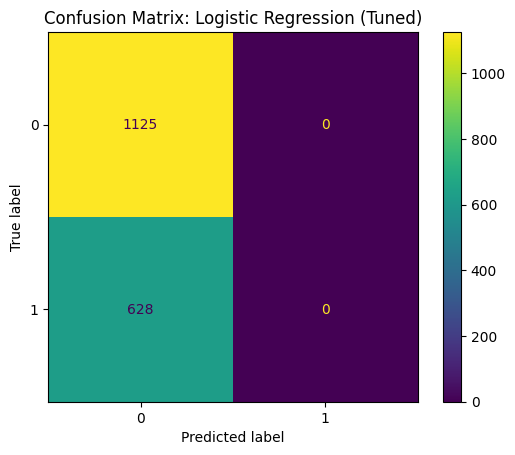

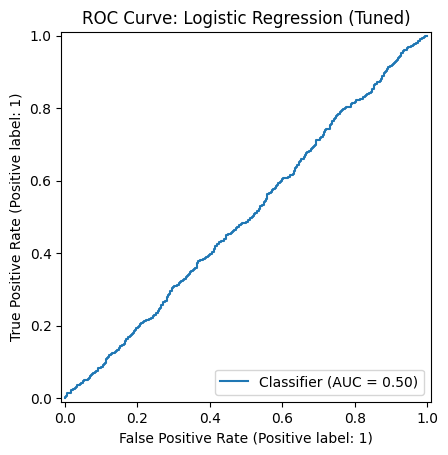


SVM (Tuned)
Score source: predict_proba
ROC AUC:  0.4929
Accuracy: 0.6418
Precision:0.0000
Recall:   0.0000
F1:       0.0000

Classification report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753



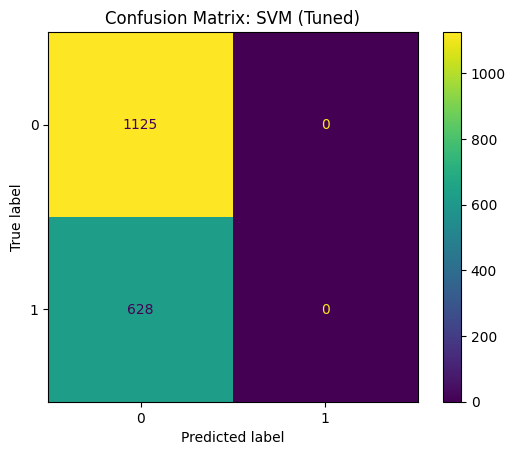

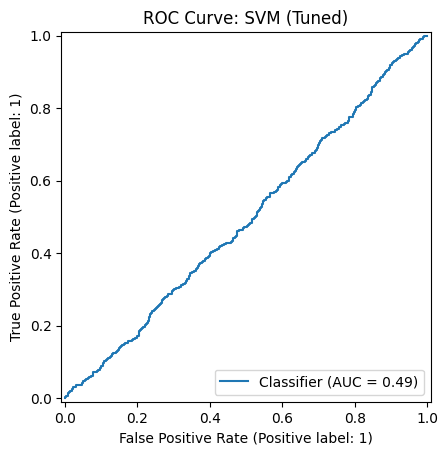


Random Forest (Tuned)
Score source: predict_proba
ROC AUC:  0.5060
Accuracy: 0.5277
Precision:0.3649
Recall:   0.4299
F1:       0.3947

Classification report:
               precision    recall  f1-score   support

           0       0.65      0.58      0.61      1125
           1       0.36      0.43      0.39       628

    accuracy                           0.53      1753
   macro avg       0.51      0.51      0.50      1753
weighted avg       0.55      0.53      0.53      1753



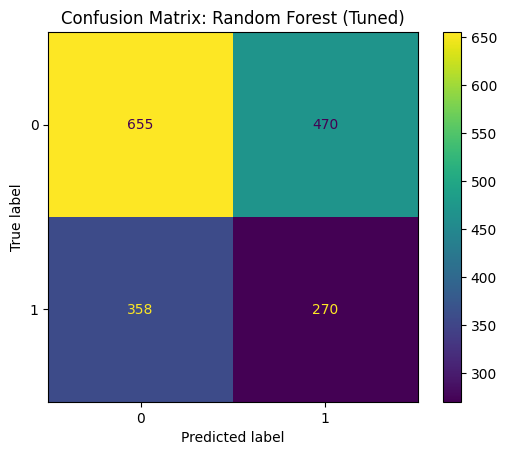

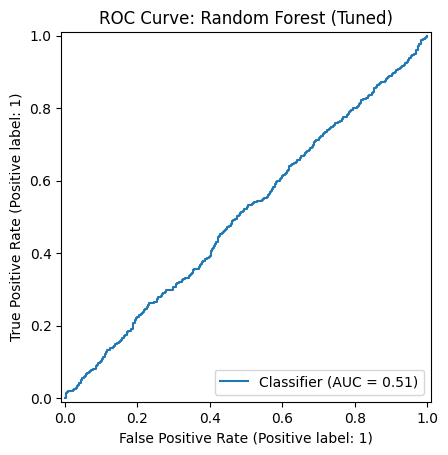


XGBoost (Tuned)
Score source: predict_proba
ROC AUC:  0.5153
Accuracy: 0.6412
Precision:0.4286
Recall:   0.0048
F1:       0.0094

Classification report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.43      0.00      0.01       628

    accuracy                           0.64      1753
   macro avg       0.54      0.50      0.40      1753
weighted avg       0.57      0.64      0.50      1753



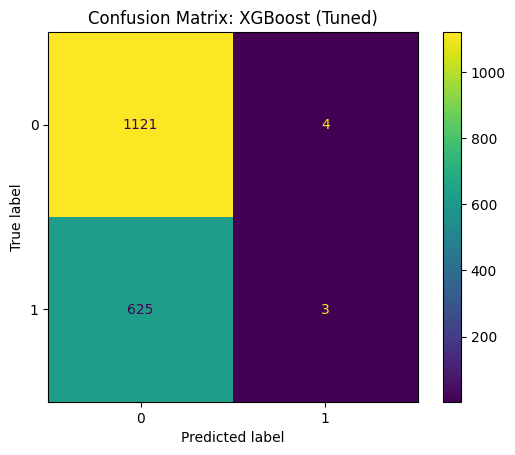

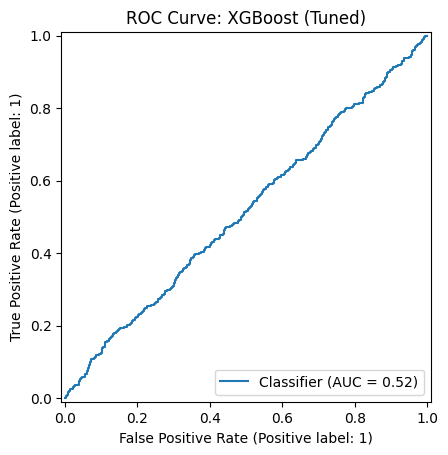


Neural Network (Tuned)
Score source: predict_proba
ROC AUC:  0.4947
Accuracy: 0.5488
Precision:0.3635
Recall:   0.3455
F1:       0.3543

Classification report:
               precision    recall  f1-score   support

           0       0.64      0.66      0.65      1125
           1       0.36      0.35      0.35       628

    accuracy                           0.55      1753
   macro avg       0.50      0.50      0.50      1753
weighted avg       0.54      0.55      0.55      1753



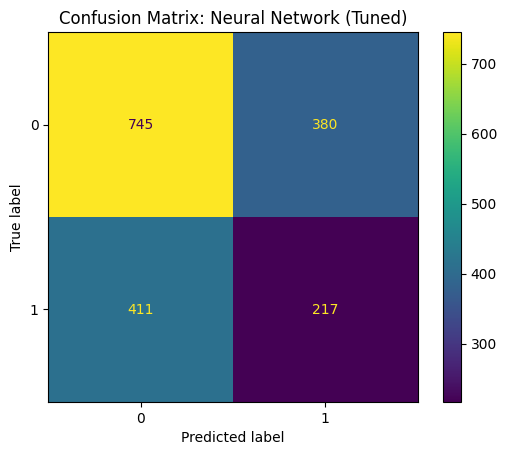

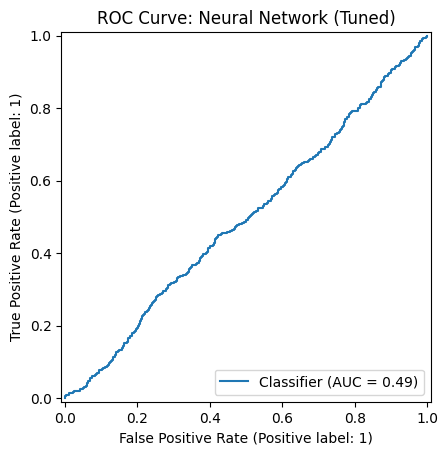


Tuned model test summary:
                          Model   ROC_AUC  Accuracy  Precision    Recall  \
3              XGBoost (Tuned)  0.515291  0.641187   0.428571  0.004777   
2        Random Forest (Tuned)  0.506010  0.527667   0.364865  0.429936   
0  Logistic Regression (Tuned)  0.500892  0.641757   0.000000  0.000000   
4       Neural Network (Tuned)  0.494684  0.548774   0.363484  0.345541   
1                  SVM (Tuned)  0.492914  0.641757   0.000000  0.000000   

         F1  
3  0.009449  
2  0.394737  
0  0.000000  
4  0.354286  
1  0.000000  


In [24]:
'''This step performs hyperparameter tuning using GridSearchCV and should not be
confused with the earlier cross validation step. The earlier cross validation
was used to compare different model types using their default settings to assess
which algorithms perform better overall. In contrast, this grid search step
actively trains and evaluates each model multiple times with different
hyperparameter combinations using cross validation on the training data.
The goal here is to identify the best configuration for each model rather than
to compare model families. All preprocessing steps are included within the
pipeline during tuning to avoid data leakage. The test set is not used at this
stage and is reserved only for final evaluation of the tuned models.

During grid search, each model is trained and evaluated multiple times
using cross validation on the training data, once for every tested
hyperparameter combination. After identifying the best performing
configuration, the model is automatically retrained on the full
training dataset (refit=True). As a result, the returned best estimator
is already fully trained and ready for final evaluation on the test set.'''

from sklearn.model_selection import GridSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grids = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],
    },
    "SVM": {
        "model__C": [0.1, 1, 10],
        "model__kernel": ["linear", "rbf"],
        "model__gamma": ["scale", "auto"],
    },
    "Random Forest": {
        "model__n_estimators": [300, 500],
        "model__max_depth": [None, 5, 10],
        "model__min_samples_split": [2, 5],
        "model__min_samples_leaf": [1, 2],
    },
    xgb_name: {
        "model__n_estimators": [300, 600, 900],
        "model__max_depth": [3, 4, 6],
        "model__learning_rate": [0.01, 0.03, 0.1],
        "model__subsample": [0.8, 1.0],
        "model__colsample_bytree": [0.8, 1.0],
        "model__reg_lambda": [0.5, 1.0, 2.0],
    },
    "Neural Network": {
        "model__hidden_layer_sizes": [(64,), (128, 64), (128, 128)],
        "model__alpha": [0.0001, 0.0005, 0.001],
        "model__learning_rate_init": [0.0005, 0.001, 0.005],
    },
}

tuned_models = {}
tuning_results = []

for name, pipe in models.items():
    print(f"\nHyperparameter tuning for: {name}")

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True
    )

    grid.fit(X_train, y_train)

    tuned_models[name] = grid.best_estimator_
    tuning_results.append({
        "Model": name,
        "Best_CV_ROC_AUC": grid.best_score_,
        "Best_Parameters": grid.best_params_,
    })

    print("Best CV ROC AUC:", round(grid.best_score_, 4))
    print("Best parameters:", grid.best_params_)

tuning_df = pd.DataFrame(tuning_results).sort_values(
    "Best_CV_ROC_AUC", ascending=False
)
print("\nHyperparameter tuning summary:\n", tuning_df)

# Final evaluation of tuned models on the held-out test set
tuned_test_results = []

for name, best_pipe in tuned_models.items():
    tuned_test_results.append(
        evaluate_model(best_pipe, X_test, y_test, title=f"{name} (Tuned)")
    )

tuned_test_df = pd.DataFrame(tuned_test_results).sort_values(
    "ROC_AUC", ascending=False
)
print("\nTuned model test summary:\n", tuned_test_df)



Ensemble Soft Voting
Score source: predict_proba
ROC AUC:  0.5036
Accuracy: 0.6110
Precision:0.3448
Recall:   0.0955
F1:       0.1496

Classification report:
               precision    recall  f1-score   support

           0       0.64      0.90      0.75      1125
           1       0.34      0.10      0.15       628

    accuracy                           0.61      1753
   macro avg       0.49      0.50      0.45      1753
weighted avg       0.53      0.61      0.53      1753



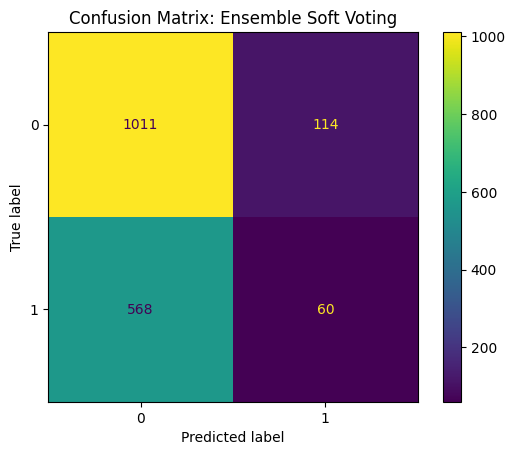

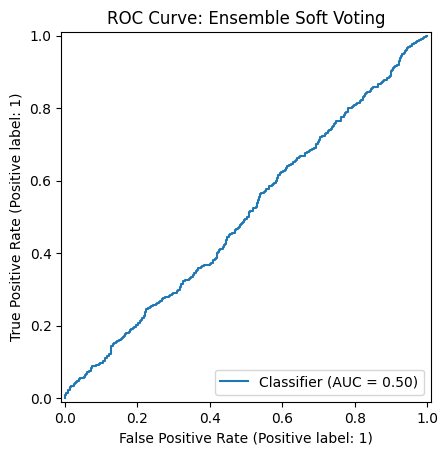


Ensemble Stacking
Score source: predict_proba
ROC AUC:  0.5037
Accuracy: 0.6418
Precision:0.0000
Recall:   0.0000
F1:       0.0000

Classification report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753



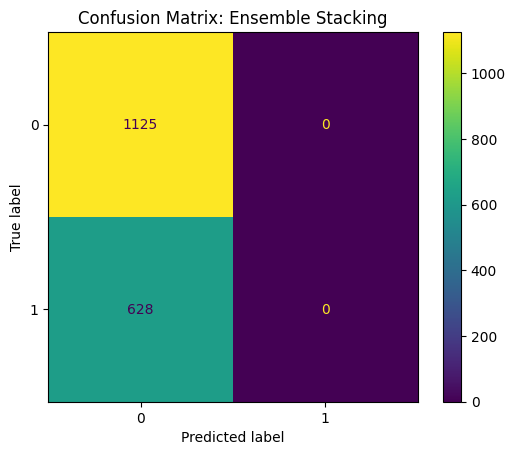

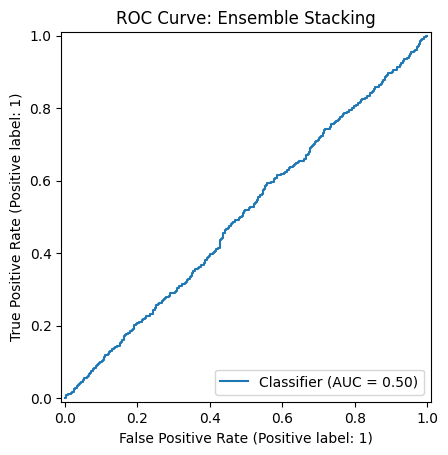


Ensemble model test summary:
                   Model   ROC_AUC  Accuracy  Precision    Recall        F1
1     Ensemble Stacking  0.503715  0.641757   0.000000  0.000000  0.000000
0  Ensemble Soft Voting  0.503584  0.610953   0.344828  0.095541  0.149626


In [25]:
'''Evaluate ensemble methods to assess whether combining multiple models
improves predictive performance compared to individual base learners.
Soft voting averages predicted probabilities, while stacking trains a
meta-learner on the outputs of base models.'''

estimators = [
    ("lr", models["Logistic Regression"]),
    ("svm", models["SVM"]),
    ("rf", models["Random Forest"]),
    ("xgb", models[xgb_name]),
    ("nn", models["Neural Network"]),
]

soft_voting = VotingClassifier(
    estimators=estimators,
    voting="soft",
    n_jobs=-1
)

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(
        max_iter=4000,
        random_state=RANDOM_STATE
    ),
    stack_method="predict_proba",
    cv=cv,
    n_jobs=-1
)

ensemble_results = []

soft_voting.fit(X_train, y_train)
ensemble_results.append(
    evaluate_model(
        soft_voting,
        X_test,
        y_test,
        title="Ensemble Soft Voting"
    )
)

stacking.fit(X_train, y_train)
ensemble_results.append(
    evaluate_model(
        stacking,
        X_test,
        y_test,
        title="Ensemble Stacking"
    )
)

ens_df = pd.DataFrame(ensemble_results).sort_values("ROC_AUC", ascending=False)
print("\nEnsemble model test summary:\n", ens_df)
